<a href="https://colab.research.google.com/github/LuigTi/CNN_NAS2/blob/main/CNN_NAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

### Dataset Class

In [2]:
class DigitsDataset(Dataset):
    '''
    Digit database from scikit-learn
    '''

    def __init__(self, mode = "train", transforms = None):
        digits = load_digits()

        #select the first 1000 datapoints as training set
        if mode == "train": 
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]

        #select 350 datapoints as training set
        elif mode == "val": 
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        
        #select the remaining datapoints as test set
        else: 
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]       
        #reshape datapoints from vector to matrix
        sample_x = sample_x.reshape(1, 8, 8) 
        sample_y = self.targets[idx]
        
        if torch.cuda.is_available(): #move on gpu if possible
          sample_x = torch.from_numpy(sample_x).to("cuda")
          sample_y = torch.from_numpy(np.array(sample_y)).to("cuda")

        return (sample_x, sample_y)

### CNN Class

In [3]:
class CNN(nn.Module):
    '''
    following the structure of:
      Conv2d → f(.) → Pooling → Flatten → Linear 1 → f(.) → Linear 2 → Softmax
    '''
    #rinomina tutto, 
    
    def __init__(self, conv_out = 8, kernel_size = 3, padding = 1, pool_size = 2, linear_out = 10):
        super(CNN, self).__init__()

        self.conv_out = conv_out # Number of filters: 8, 16, 32
        self.kernel_size = kernel_size # Kernel= (3x3) or (5x5)
        self.padding = padding # Padding= 1 or 2
        self.pool_size = pool_size # 2x2 OR Identity
        self.linear_out = linear_out # Number of neurons: 10, 20, 30, 40, 50, 60, 70, 80, 90, 100
        
        if True:
          #find the size after the convolutional layers
          size = 8 - self.kernel_size + 2 * self.padding + 1
          #find the size after the pooling layer
          size = (size - self.pool_size) / (self.pool_size) + 1
          #find the size after flattening
          size = int(size**2 * self.conv_out)


        #convolutional layers
        self.cnn =  nn.Conv2d(in_channels = 1, out_channels = conv_out, kernel_size = kernel_size, stride = 1, padding = padding)
        self.activation1 = nn.ReLU() # or sigmoid, tanh, softplus, elu
        self.pool = nn.MaxPool2d(kernel_size = pool_size) # or avg pool

        #fully connected layers
        self.linear1 = nn.Linear(in_features = size, out_features = linear_out)
        self.activation2 = nn.ReLU() # or sigmoid, tanh, softplus, elu
        self.linear2 = nn.Linear(in_features = linear_out, out_features = 10)
        self.softmax = nn.LogSoftmax(dim=1)

        #loss funtion
        self.nll = nn.NLLLoss(reduction="none") 
    
    #classify method to find the prediccion of a datapoint
    def classify(self, x):
        #input goes through all the layers
        x = self.cnn(x)
        x = self.activation1(x)
        x = self.pool(x)
        #get flattened before fully conneted layers
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.activation2(x)
        x = self.linear2(x)
        log_prob = self.softmax(x)
        #find prediction
        y_pred = torch.argmax(log_prob, dim = 1).long()        
        return y_pred

    #foward method for the foward pass
    def forward(self, x, y, reduction="avg"):
        #input goes through all the layers
        x = self.cnn(x)
        x = self.activation1(x)
        x = self.pool(x)
        #get flattened before fully conneted layers
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.activation2(x)
        x = self.linear2(x)
        log_prob = self.softmax(x)
        
        #find the loss (it has as input the log_prob and targets)
        loss = self.nll(log_prob, y)
        #reduction for loss over a batch (either summ or mean)
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

    #find how many classifying mistakes were made
    def missclassified_datapoints(self, predictions, targets):
        #number of differences in the two vectors
        return torch.sum(predictions != targets) 

### Train and Evaluation Loops (one epoch) and Plot Function

In [4]:
def train_loop(dataloader, model, optimizer):

    #counters for train loss and missclassified datapoints
    loss_counter = 0
    missclass_counter = 0

    #get model on train mode
    model.train()

    #for datapoint and target in dataloader
    for (X, y) in dataloader:

        #find the loss by giving a prediction regarding the datapoint
        loss = model(X, y, reduction = "sum")
        #add loss to counter
        loss_counter += loss

        #classify each datapoint and count missclassified points
        predictions = model.classify(X)
        missclassified_datapoints = model.missclassified_datapoints(predictions, y)
        #add missclassified datapoints to counter
        missclass_counter += missclassified_datapoints


        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    
    #find average loss and average classification error over the epoch 
    dataloader_size = len(dataloader.dataset)
    average_loss = float(loss_counter / dataloader_size)
    average_ce = float(missclass_counter / dataloader_size)
    
    #print average loss and average classification error 
    print("\033[95mTRAINING\033[0m")
    print(f"        average train loss => {average_loss}")
    print(f"        average classification error => {average_ce}")
    print("")
    
    return average_loss, average_ce


In [5]:
def evaluation_loop(dataloader, model, optimizer, mode = "validation"):


    #counters for train loss and missclassified datapoints
    loss_counter = 0
    missclass_counter = 0

    #get model to eval mode
    model.eval()


    #to not save the gradients
    with torch.no_grad():
      #for datapoint and target in dataloader
      #tqdm to make progress bar
      for (X, y) in dataloader:


        #find the loss by giving a prediction regarding the datapoint
        loss = model(X, y, reduction = "sum")
        #add loss to counter
        loss_counter += loss

        #classify each datapoint and count missclassified points
        predictions = model.classify(X)
        missclassified_datapoints = model.missclassified_datapoints(predictions, y)
        #add missclassified datapoints to counter
        missclass_counter += missclassified_datapoints



    #find average loss and average classification error over the epoch 
    dataloader_size = len(dataloader.dataset)
    average_loss = float(loss_counter / dataloader_size)
    average_ce = float(missclass_counter / dataloader_size)
      
      
    #print average loss and average classification error 
    if mode == "validation":
      print("\033[95mVALIDATION\033[0m")
    else:
      print("\033[92mTESTING\033[0m")

    print(f"        average {mode} loss => {average_loss}")
    print(f"        average {mode} classification error => {average_ce}")
    print("")

    return average_loss, average_ce


In [20]:
#function to plot
def plot_results(train_loss_list, train_ce_list, val_loss_list, val_ce_list, test_loss_result, test_ce_result):
    #number of epoches
    n_epochs = len(train_loss_list)
    # Plotting train loss
    plt.plot(range(1, n_epochs + 1), train_loss_list, label="Train Loss")

    # Plotting train classification error
    plt.plot(range(1, n_epochs + 1), train_ce_list, label="Train Classification Error")

    # Plotting validation loss
    plt.plot(range(1, n_epochs + 1), val_loss_list, label="Validation Loss")

    # Plotting validation classification error
    plt.plot(range(1, n_epochs + 1), val_ce_list, label="Validation Classification Error")

    # Plotting test loss
    plt.plot(range(1, n_epochs + 1), [test_loss_result] * n_epochs, label="Test Loss", linestyle="--")

    # Plotting test classification error
    plt.plot(range(1, n_epochs + 1), [test_ce_result] * n_epochs, label="Test Classification Error", linestyle="--")

    # Set plot labels and title
    plt.xlabel("Epochs")
    plt.ylabel("Loss / Classification Error")
    plt.title("Training and Evaluation Results")

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

### dataloaders and Full Training and Testing

In [7]:
#training, validation and test sets.
train_set = DigitsDataset(mode="train")
val_set = DigitsDataset(mode="val")
test_set = DigitsDataset(mode="test")

#data loaders.
training_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

#initializa model and optimizer
cnn = CNN().to("cuda")
opt = torch.optim.Adamax(cnn.parameters(), lr=1e-3, weight_decay=1e-5)
number_epoch = 20

  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH NUMBER 0
TRAINING
        average train loss => 0.09471369534730911
        average classification error => 0.020000001415610313

VALIDATION
        average validation loss => 0.1829896718263626
        average validation classification error => 0.05428571254014969

EPOCH NUMBER 1
TRAINING
        average train loss => 0.09174303710460663
        average classification error => 0.020000001415610313

VALIDATION
        average validation loss => 0.1795685738325119
        average validation classification error => 0.05428571254014969

EPOCH NUMBER 2
TRAINING
        average train loss => 0.08948628604412079
        average classification error => 0.01900000125169754

VALIDATION
        average validation loss => 0.17543545365333557
        average validation classification error => 0.051428571343421936

EPOCH NUMBER 3
TRAINING
        average train loss => 0.08705365657806396
        average classification error => 0.02200000174343586

VALIDATION
        average validation loss =>

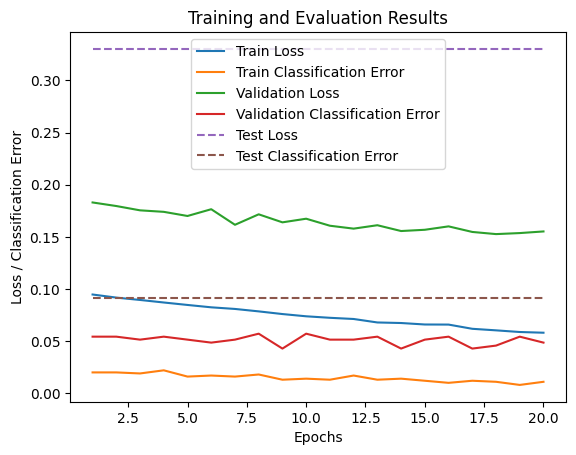

In [23]:
#initialize empty lists
train_loss_list = []
train_ce_list = []
val_loss_list =[]
val_ce_list =[]
test_loss_result =[]
test_ce_result =[]

#for number of epoches
#tqdm to make progress bar
for i in tqdm(range(number_epoch)):

  print(f"\033[96mEPOCH NUMBER {i}\033[0m")
  train_loss, train_ce =  train_loop(dataloader = training_loader, model = cnn, optimizer = opt)
  train_loss_list.append(train_loss)
  train_ce_list.append(train_ce)

  val_loss, val_ce = evaluation_loop(dataloader = val_loader, model = cnn, optimizer = opt)
  val_loss_list.append(val_loss)
  val_ce_list.append(val_ce)

test_loss, test_ce = evaluation_loop(dataloader = test_loader, model = cnn, optimizer = opt, mode = "test")
test_loss_result.append(test_loss)
test_ce_result.append(test_ce)

#plot graphs
plot_results(train_loss_list, train_ce_list, val_loss_list, val_ce_list, test_loss_result, test_ce_result)
